In [29]:
import numpy as np
from bokeh.plotting import figure, output_notebook, show

output_notebook()
np.random.seed(103472)

Loading BokehJS ...

Let's simulate a process where an individual flips a coin, and moves forward by one step if the coin lands heads, otherwise makes a step backward. The individual will flip the coin 16 times. Now, let's repeat the experiment 1,000 times and record how many steps forward or backward each individual moved.

In [82]:
results = list()
cumsums = list()
for i in range(1000):
    moves = np.where(np.round(np.random.uniform(low=0, high=1, size=16)) == 0, -1, 1)
    cumsums.append(np.cumsum(moves))
    final = np.sum(moves)
    results.append(final)

p = figure(title='Results of a 1,000 coin flip simulations')
p.title.align = 'center'
high, edges = np.histogram(results, bins=30)
p.quad(top=high, bottom=0, left=edges[:-1], right=edges[1:])
show(p)

In [80]:
p = figure(x_axis_label='step number', y_axis_label='position')
p.multi_line(xs=[list(range(16)) for i in range(1000)], ys=cumsums, alpha=.10)
p.line(x=(3, 3), y=(-15, 15), line_dash='dotted', color='red')
p.line(x=(7, 7), y=(-15, 15), line_dash='dotted', color='red')
p.line(x=(15, 15), y=(-15, 15), line_dash='dotted', color='red')
show(p)

In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import scale

from rethinking.stan import StanCache
from rethinking.utils import hpdi

np.set_printoptions(precision=3)

In [2]:
DATA_FOLDER = '../data'

HOWELL_PATH = os.path.join(DATA_FOLDER, 'howell1.csv')

In [3]:
howell_full = pd.read_csv(HOWELL_PATH)
howell = howell_full[howell_full.age >= 18]
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
howell.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [5]:
height = howell.loc[howell.age >= 18, 'height']

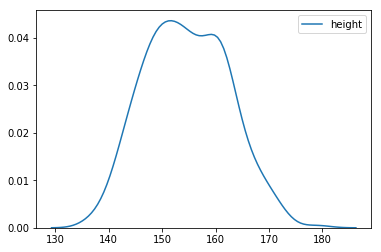

In [6]:
sns.kdeplot(height)

$$
\begin{align}
    h_i &\sim Normal(\mu, \sigma) \\
    \mu &\sim Normal(178, 20) \\
    \sigma &\sim Uniform(0, 50)
\end{align}
$$

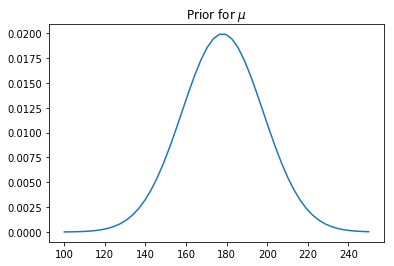

In [7]:
x = np.linspace(start=100, stop=250, num=50)
y = stats.norm(178, 20).pdf(x)
plt.plot(x, y)
plt.title('Prior for $\mu$')
plt.show()

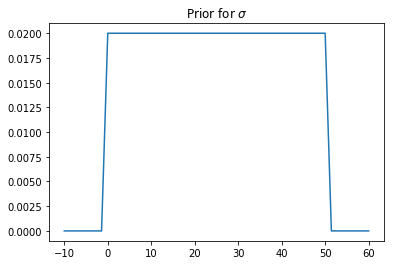

In [8]:
x = np.linspace(start=-10, stop=60, num=50)
y = stats.uniform(0, 50).pdf(x)
plt.plot(x, y)
plt.title('Prior for $\sigma$')
plt.show()

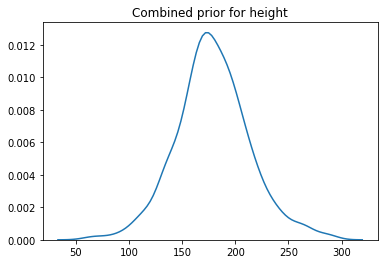

In [9]:
x = np.linspace(start=100, stop=1000, num=100)
sample_mu = np.random.normal(loc=178, scale=20, size=1000)
sample_sigma = np.random.uniform(low=0, high=50, size=1000)
prior_h = np.random.normal(loc=sample_mu, scale=sample_sigma, size=1000)
sns.kdeplot(prior_h)
plt.title('Combined prior for height')
plt.show()

In [10]:
m4_1 = StanCache(filename='../models/height.stan', cache_path='../cache').compile()
m4_1.model_code

data {
    int<lower=0> N;                      // number of observations
    real<lower=0, upper=200> height[N];
}
parameters {
    real<lower=0, upper=200> mu;
    real<lower=0, upper=50> sigma;
}
model {
    sigma ~ uniform(0, 50);
    mu ~ normal(178, 20);
    height ~ normal(mu, sigma);
}



In [11]:
height_data = dict(
    N=len(height),
    height=height
)

fit4_1 = m4_1.sampling(data=height_data, iter=1000, chains=4)
fit4_1

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_4a78e70403dbc23b3cffbc3b6451b058.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    154.61  9.4e-3   0.42 153.79 154.33  154.6 154.89 155.47   2000    1.0
sigma   7.76  8.1e-3    0.3    7.2   7.56   7.75   7.94   8.38   1352    1.0
lp__  -892.2    0.04   1.05 -895.0 -892.6 -891.8 -891.4 -891.2    707    1.0

Samples were drawn using NUTS at Sun Mar 11 22:07:12 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

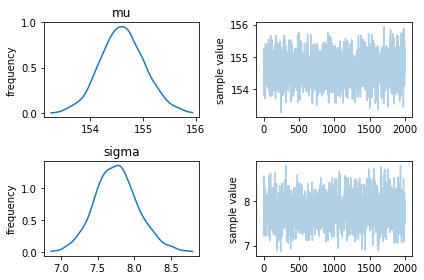

In [12]:
fit4_1.plot()
plt.tight_layout()
plt.show()

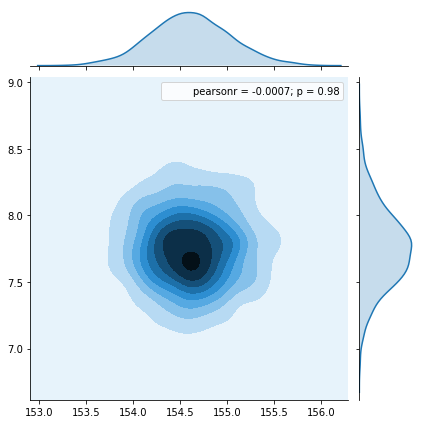

In [13]:
posterior = fit4_1.extract(permuted=True)
sns.jointplot(x='mu', y='sigma', data=posterior, kind='kde')

# Sampling from the posterior

In [14]:
sample_rows = np.random.choice(a=range(len(posterior['lp__'])), replace=True, size=10000)
sample_mu = posterior['mu'][sample_rows]
sample_sigma = posterior['sigma'][sample_rows]

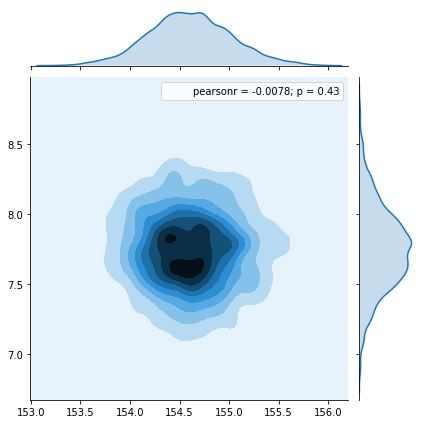

In [15]:
sns.jointplot(x=sample_mu, y=sample_sigma, kind='kde')

In [16]:
hpdi_mu = hpdi(samples=sample_mu, prob=.95)
hpdi_sigma = hpdi(samples=sample_sigma, prob=.95)
print(f'HPDI mu: {hpdi_mu}\nHPDI sigma: {hpdi_sigma}')

HPDI mu: (153.77454003602867, 155.4335418396508)
HPDI sigma: (7.179855609761088, 8.363976760260666)


# Adding a predictor

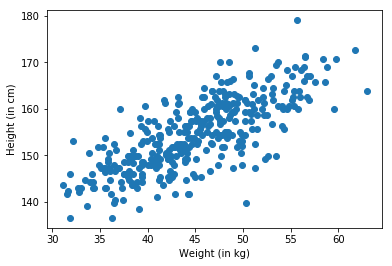

In [17]:
plt.scatter(x='weight', y='height', data=howell)
plt.xlabel('Weight (in kg)')
plt.ylabel('Height (in cm)')
plt.show()

$$
\begin{align}
    h_i &\sim Normal(\mu_i, \sigma) \\
    \mu_i &= \alpha + \beta x_i \\
    \alpha &\sim Normal(178, 100) \\
    \beta &\sim Normal(0, 10) \\
    \sigma &\sim Uniform(0, 50)
\end{align}
$$

In [18]:
sm2 = StanCache(filename='../models/predictor.stan', cache_path='../cache').compile()
sm2.model_code

data {
    int<lower=0> N;
    vector[N] x;
    vector[N] h;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    //sigma ~ uniform(0, 50);
    alpha ~ normal(178, 100);
    beta ~ normal(0, 10);
    h ~ normal(alpha + beta * x, sigma);
}



We found that the Uniform(0, 50) prior for $\sigma$ as suggest by the author (McElreath) causes an extremely low effective sample size (ESS). We commented out the prior to fix the issue. Further analyses should be conducted to understand why this is happening since:
* The posterior distribution of $\sigma$ is within the interval (0, 50)
* The default prior for sigma, when not manually specified by the user, is a uniform prior bounded between $0$ and $\inf$. This is much larger than the interval (0, 50)

In [19]:
predictor_data = dict(
    N=len(howell.height),
    x=howell.weight,
    h=howell.height)

In [20]:
fit2 = sm2.sampling(data=predictor_data, iter=4000)
fit2

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/gianluca/git/rethinking/src/rethinking/stan.py:95: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(results, f)


Inference for Stan model: anon_model_3af82d1625525dbd730bf0dcb2fe1b7f.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha 113.89    0.04   1.91 110.19 112.53  113.9 115.19 117.61   2591    1.0
beta     0.9  8.3e-4   0.04   0.82   0.88    0.9   0.93   0.99   2566    1.0
sigma    5.1  3.3e-3    0.2   4.74   4.96   5.09   5.23    5.5   3554    1.0
lp__  -747.6    0.02    1.2 -750.7 -748.2 -747.3 -746.7 -746.2   2711    1.0

Samples were drawn using NUTS at Mon Mar 12 19:21:05 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [21]:
samples2 = fit2.extract(permuted=True)
s = pd.DataFrame(samples2)
s.describe()

,alpha,beta,sigma,lp__
count,8000.000000,8000.000000,8000.000000,8000.000000
mean,113.889942,0.904791,5.101670,-747.644842
std,1.914472,0.042099,0.195439,1.202966
min,106.120375,0.760510,4.492672,-754.868032
25%,112.534350,0.876111,4.964124,-748.214691
50%,113.901202,0.904980,5.094346,-747.331305
75%,115.189788,0.934110,5.230897,-746.760659
max,120.615644,1.067379,5.851855,-746.133715


The program doesn't seem to contain bugs. Samples from the priors looks okay.

In [22]:
np.corrcoef(s.drop('lp__', axis='columns').T
            .as_matrix())

array([[ 1.   , -0.99 ,  0.009],
       [-0.99 ,  1.   , -0.011],
       [ 0.009, -0.011,  1.   ]])

The correlation matrix shows an extremely high negative correlation between $\alpha$ and $\beta$. This can be fixed centering the predictors.

# Centering

In [23]:
howell['weight_c'] = scale(X=howell['weight'], with_mean=True, with_std=False)

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


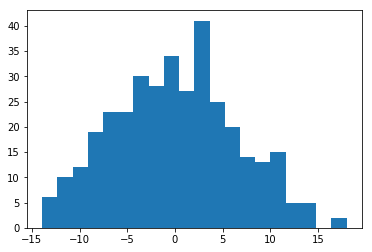

In [24]:
plt.hist(howell.weight_c, bins=20)
plt.show()

In [25]:
predictor_data = dict(
    N=len(howell.height),
    x=howell.weight_c,
    h=howell.height)

fit3 = sm2.sampling(data=predictor_data, iter=4000)
fit3

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/gianluca/git/rethinking/src/rethinking/stan.py:95: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(results, f)


Inference for Stan model: anon_model_3af82d1625525dbd730bf0dcb2fe1b7f.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  154.6  3.0e-3   0.27 154.07 154.41  154.6 154.78 155.13   8000    1.0
beta    0.91  4.7e-4   0.04   0.82   0.88   0.91   0.93   0.99   8000    1.0
sigma    5.1  2.2e-3   0.19   4.74   4.97    5.1   5.23    5.5   8000    1.0
lp__  -747.4    0.02    1.2 -750.5 -747.9 -747.1 -746.5 -746.0   4043    1.0

Samples were drawn using NUTS at Mon Mar 12 19:21:06 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [26]:
samples3 = fit3.extract(permuted=True)
s3 = pd.DataFrame(samples3)

np.corrcoef(s3.drop('lp__', axis='columns').T
            .as_matrix())

array([[ 1.   , -0.004, -0.008],
       [-0.004,  1.   , -0.027],
       [-0.008, -0.027,  1.   ]])

Note that the posterior mean and standard deviation for $\beta$ and $\sigma$ is the same as the one in the model without centering the predictors. The effective sample size though is much larger when the model's predictors are centered. Of course, centering the predictors affects the intercept ($\alpha$).

# Plotting prosterior inference against the data

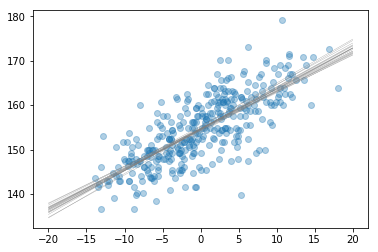

In [27]:
plt.scatter(x='weight_c', y='height', data=howell, alpha=.35)
x = np.array([-20, 20])
for i in np.random.choice(range(8000), size=20, replace=False):
    f = lambda x: s3.loc[i, 'alpha'] + s3.loc[i, 'beta'] * x
    plt.plot(x, f(x), linewidth=0.25, c='grey')
plt.show()

# Polynomial regression

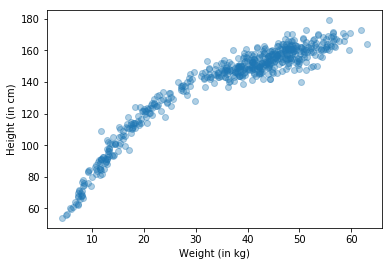

In [28]:
plt.scatter(x='weight', y='height', data=howell_full, alpha=.35)
plt.xlabel('Weight (in kg)')
plt.ylabel('Height (in cm)')
plt.show()

In [29]:
howell_full['weight_s'] = scale(
    X=howell_full.weight, with_mean=True, with_std=True)

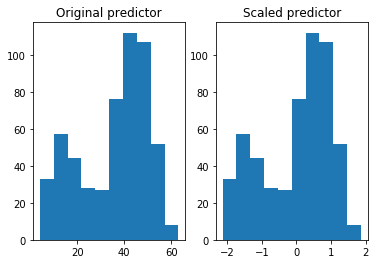

In [30]:
plt.subplot(121)
plt.hist(howell_full.weight)
plt.title('Original predictor')

plt.subplot(122)
plt.hist(howell_full.weight_s)
plt.title('Scaled predictor')
plt.show()

In [31]:
sm3 = StanCache(filename='../models/poly.stan', cache_path='../cache').compile()
sm3.model_code

data {
    int<lower=0> N;                  // n observations
    int<lower=0> M;                  // n features
    vector[N] weight;
    vector[N] weight_2;              // weight^2
    vector[N] height;
}
parameters {
    real alpha;
    real beta[M];
    real<lower=0> sigma;
}
model {
    alpha ~ normal(178, 100);
    beta ~ normal(0, 10);
    height ~ normal(alpha + beta[1] * weight + beta[2] * weight_2, sigma);
}



In [32]:
poly_data = dict(
    N=len(howell_full.height),
    M=2,
    weight=howell_full.weight_s,
    weight_2=np.power(howell_full.weight_s, 2),
    height=howell_full.height)

fit4 = sm3.sampling(data=poly_data, iter=4000)
fit4

/home/gianluca/.virtualenvs/rethinking/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_8a020c4da28c7aa4a258598b82a44c16.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   146.67  6.0e-3   0.38 145.93 146.42 146.67 146.92 147.41   3930    1.0
beta[0]  21.38  4.2e-3   0.29   20.8  21.18  21.37  21.57  21.95   4845    1.0
beta[1]   -8.4  4.9e-3   0.29  -8.97  -8.59   -8.4  -8.21  -7.84   3458    1.0
sigma     5.78  2.1e-3   0.18   5.45   5.66   5.78   5.89   6.13   6983    1.0
lp__     -1226    0.02   1.45  -1230  -1227  -1226  -1225  -1224   3430    1.0

Samples were drawn using NUTS at Mon Mar 12 19:20:09 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

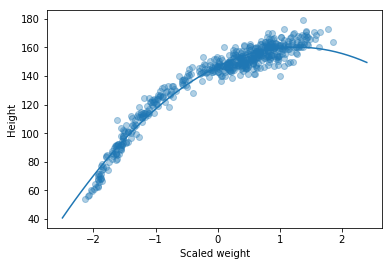

In [33]:
x = np.arange(start=-2.5, stop=2.5, step=0.1)
f = np.vectorize(lambda x: 146.67 + 21.38 * x -8.41 * np.power(x, 2))
y = f(x)
plt.scatter(x='weight_s', y='height', data=howell_full, alpha=.35)
plt.plot(x, y)
plt.xlabel('Scaled weight')
plt.ylabel('Height')
plt.show()